# Example of parsing a .dec decay file with Lark

In [107]:
from lark import Lark, Tree

from decaylanguage import data

In [121]:
with data.open_text(data, 'decfile.lark') as f:
    grammar = f.read()

with data.open_text(data, 'test_example_Dst.dec') as f:
    dec_file = f.read()

For illustration - the grammar Lark file:

In [126]:
print(grammar)

start : _NEWLINE? (line _NEWLINE)+ ("End" _NEWLINE)?
?line : define | pythia_def | alias | chargeconj | commands | decay | cdecay | setlspw

pythia_def : "PythiaBothParam" LABEL ":" LABEL "=" (LABEL | SIGNED_NUMBER)

setlspw : "SetLineshapePW" label label label value

cdecay : "CDecay" label

define : "Define" label value

alias : "Alias" label label

chargeconj : "ChargeConj" label label

?commands : global_photos

global_photos : boolean_photos

boolean_photos : "yesPhotos" -> yes
                | "noPhotos"  -> no

decay : "Decay" particle _NEWLINE decayline+ "Enddecay"
decayline : value particle* photos? model _NEWLINE // There is always a ; here
value : SIGNED_NUMBER
photos : "PHOTOS"

label : LABEL
particle : LABEL // Add full particle parsing here

model : MODEL_NAME model_options?
model_options : (value | LABEL)+

// model : model_generic
// model_helamp : "HELAMP" (SIGNED_NUMBER SIGNED_NUMBER)+

// Terminal defintions
// To use a fast parser, we need to avoid conflicts

%impo

For illustration - the .dec decay file:

In [128]:
print(dec_file)

# Example decay chain for testing purposes

Alias      D0sig             D0
Alias      anti-D0sig        anti-D0
ChargeConj D0sig             anti-D0sig

Alias      D*+sig            D*+
Alias      D*-sig            D*-
ChargeConj D*+sig            D*-sig


Decay D*+
0.6770    D0  pi+                    VSS;
0.3070    D+  pi0                    VSS;
0.0160    D+  gamma                  VSP_PWAVE;
Enddecay

Decay D*-
0.6770    anti-D0  pi-                VSS;
0.3070    D-       pi0                VSS;
0.0160    D-       gamma              VSP_PWAVE;
Enddecay

Decay D0
1.0   K-      pi+                  PHSP;
Enddecay

Decay D+
1.0   K-   pi+   pi+   pi0    PHSP;
Enddecay

Decay pi0
0.988228297   gamma   gamma                   PHSP;
0.011738247   e+      e-      gamma           PI0_DALITZ;
0.000033392   e+      e+      e-      e-      PHSP;
0.000000065   e+      e-                      PHSP;
Enddecay



Parse the .dec decay file.

In [134]:
l = Lark(grammar, parser='lalr', lexer='standard')
parsed_dec_file = l.parse(dec_file)

In [135]:
def number_of_decays(parsed_file):
    """Returns the number of particle decays defined in the parsed .dec file."""
    return len(list(parsed_file.find_data('decay')))

print('# of decays in file =',  number_of_decays(parsed_dec_file))

# of decays in file = 5


In [136]:
def list_of_decay_trees(parsed_file):
    """Return a list of the actual decays defined in the .dec file."""
    list_of_decays = list(parsed_file.find_data('decay'))
    return list_of_decays

list_of_decay_trees(parsed_dec_file)

[Tree(decay, [Tree(particle, [Token(LABEL, 'D*+')]), Tree(decayline, [Tree(value, [Token(SIGNED_NUMBER, '0.6770')]), Tree(particle, [Token(LABEL, 'D0')]), Tree(particle, [Token(LABEL, 'pi+')]), Tree(model, [Token(MODEL_NAME, 'VSS')])]), Tree(decayline, [Tree(value, [Token(SIGNED_NUMBER, '0.3070')]), Tree(particle, [Token(LABEL, 'D+')]), Tree(particle, [Token(LABEL, 'pi0')]), Tree(model, [Token(MODEL_NAME, 'VSS')])]), Tree(decayline, [Tree(value, [Token(SIGNED_NUMBER, '0.0160')]), Tree(particle, [Token(LABEL, 'D+')]), Tree(particle, [Token(LABEL, 'gamma')]), Tree(model, [Token(MODEL_NAME, 'VSP_PWAVE')])])]),
 Tree(decay, [Tree(particle, [Token(LABEL, 'D*-')]), Tree(decayline, [Tree(value, [Token(SIGNED_NUMBER, '0.6770')]), Tree(particle, [Token(LABEL, 'anti-D0')]), Tree(particle, [Token(LABEL, 'pi-')]), Tree(model, [Token(MODEL_NAME, 'VSS')])]), Tree(decayline, [Tree(value, [Token(SIGNED_NUMBER, '0.3070')]), Tree(particle, [Token(LABEL, 'D-')]), Tree(particle, [Token(LABEL, 'pi0')]), Tr

In [137]:
def get_decay_mode_details(decay_mode_Tree):
    """Parse a decay mode tree and return the relevant bits of information in it."""
    bf = [x for x in decay_mode_Tree.find_data('value')][0].children[0].value if len([x for x in decay_mode_Tree.find_data('value')])==1 else None
    bf = float(bf)
    products = tuple([p.children[0].value for p in decay_mode_Tree.children if isinstance(p,Tree) and p.data=='particle'])
    model = [x for x in decay_mode_Tree.find_data('model')][0].children[0].value if len([x for x in decay_mode_Tree.find_data('model')])==1 else None
    return (bf, products, model)

Finally, digest all Lark's Tree objects parsed and collect the information of all defined decays.

In [138]:
decays = {}

for tree in list_of_decay_trees(parsed_dec_file):
    if tree.data == 'decay':
        if tree.children[0].children[0].value in decays:
            print('Decays of particle %s are redefined! Please check your .dec file.' % tree.children[0].children[0].value)
        decays[tree.children[0].children[0].value] = []
        for decay_mode in tree.find_data('decayline'):
            decays[tree.children[0].children[0].value].append(get_decay_mode_details(decay_mode))

For illustration - print out the decay modes:

In [145]:
def print_decay(dec, final_state):
    """Pretty print of the decay modes of a given particle."""
    print(dec)
    for fs in final_state:
        print('%12g : %50s %15s' % (fs[0], '  '.join(p for p in fs[1]), fs[2]))

In [146]:
print_decay('pi0', decays['pi0'])

pi0
    0.988228 :                                       gamma  gamma            PHSP
   0.0117382 :                                      e+  e-  gamma      PI0_DALITZ
  3.3392e-05 :                                     e+  e+  e-  e-            PHSP
     6.5e-08 :                                             e+  e-            PHSP


In [147]:
for particle, decay_info in decays.items():
    print_decay(particle, decay_info)

D*+
       0.677 :                                            D0  pi+             VSS
       0.307 :                                            D+  pi0             VSS
       0.016 :                                          D+  gamma       VSP_PWAVE
D*-
       0.677 :                                       anti-D0  pi-             VSS
       0.307 :                                            D-  pi0             VSS
       0.016 :                                          D-  gamma       VSP_PWAVE
D0
           1 :                                            K-  pi+            PHSP
D+
           1 :                                  K-  pi+  pi+  pi0            PHSP
pi0
    0.988228 :                                       gamma  gamma            PHSP
   0.0117382 :                                      e+  e-  gamma      PI0_DALITZ
  3.3392e-05 :                                     e+  e+  e-  e-            PHSP
     6.5e-08 :                                             e+  e-            PHS

For illustration - produce a dot plot of a decay Tree:

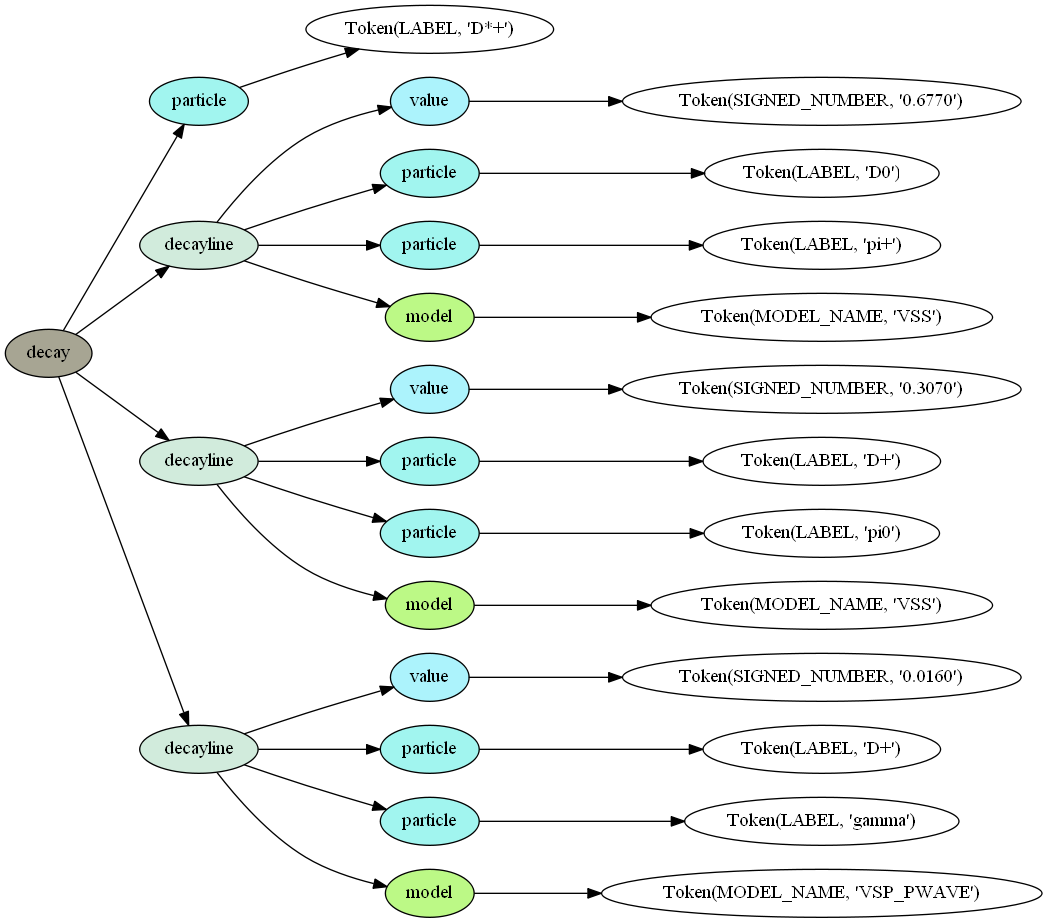

In [148]:
from lark.tree import pydot__tree_to_png

pydot__tree_to_png(list_of_decay_trees(parsed_dec_file)[0], filename='decay.png', rankdir="LR")

from IPython.display import Image
Image(filename="decay.png")